## Validation of network modules

This notebook performs a couple of analyses to validate the co-expression modules generated:
1. We examine the size of modules
2. We examine how co-operonic/co-regulonic genes are clustered into a few modules. A similar analysis can be found [here](spell_vs_counts_experiment/1a_compare_SPELL_vs_counts_correlation.ipynb) comparing within vs between edges for a given regulon/geneset.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scripts import utils, paths

np.random.seed(1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# User params
# Params to examine module size
clustering_method_list = ["dbscan", "hierarchal", "affinity"]

# Params for regulon/operon coverage
# Clustering method to examine regulon/operon coverage
# This method needs to be one of the ones listed above in `clustering_method_list`
method_toexamine = "affinity"

# Remove modules of this size or greater for analysis looking at coverage of regulon/operons
module_size_threshold = 1000

# Seed to use to randomly sample a matched-sized set of genes
# to compare against regulon/operon composition
sample_seed = 1

# Gene subset
gene_subset = "all"

# How was data processed
processed = "spell"

## Examine size of modules

This will serve as a quick check that we are using reasonable clustering params in [2_get_network_communities.ipynb](2_get_network_communities.ipynb)

In [3]:
for method_name in clustering_method_list:
    print(f"Modules using clustering method: {method_name}")
    pao1_membership_filename = os.path.join(
        paths.LOCAL_DATA_DIR,
        f"pao1_modules_{method_name}_{gene_subset}_{processed}.tsv",
    )
    pa14_membership_filename = os.path.join(
        paths.LOCAL_DATA_DIR,
        f"pa14_modules_{method_name}_{gene_subset}_{processed}.tsv",
    )

    pao1_membership = pd.read_csv(
        pao1_membership_filename, sep="\t", header=0, index_col=0
    )
    pa14_membership = pd.read_csv(
        pa14_membership_filename, sep="\t", header=0, index_col=0
    )
    # Note: Sort module ids by occurence for plotting later
    pao1_membership.sort_values(by="module id", ascending=False, inplace=True)
    pa14_membership.sort_values(by="module id", ascending=False, inplace=True)

    print(pao1_membership["module id"].value_counts())
    print(pa14_membership["module id"].value_counts())

Modules using clustering method: dbscan
 0     2933
-1     2358
 2       46
 13      16
 16      13
 8       12
 10      12
 21      10
 11      10
 1        9
 18       9
 3        9
 30       8
 6        8
 22       7
 14       7
 23       7
 7        6
 19       6
 17       6
 12       5
 20       5
 24       5
 28       5
 32       5
 31       5
 9        5
 25       5
 29       5
 26       5
 33       5
 5        4
 27       4
 15       4
 4        4
Name: module id, dtype: int64
-1     2978
 0     2264
 12      71
 3       43
 4       32
 16      31
 41      26
 11      25
 29      22
 10      18
 36      16
 5       15
 25      14
 52      13
 30      13
 37      12
 38      12
 1       12
 8       12
 21      11
 33      11
 42      10
 43       9
 32       9
 23       8
 13       8
 45       8
 48       8
 6        8
 2        8
 28       8
 55       7
 51       7
 18       7
 26       7
 39       7
 7        7
 14       6
 47       6
 17       6
 31       6
 20       6
 24   

In [4]:
# plotting function
def plot_dist_modules(clustering_method_list, gene_subset):

    # Set up the matplotlib figure
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(len(clustering_method_list)):
        pao1_membership_filename = os.path.join(
            paths.LOCAL_DATA_DIR,
            f"pao1_modules_{clustering_method_list[i]}_{gene_subset}_{processed}.tsv",
        )
        pa14_membership_filename = os.path.join(
            paths.LOCAL_DATA_DIR,
            f"pa14_modules_{clustering_method_list[i]}_{gene_subset}_{processed}.tsv",
        )

        pao1_membership = pd.read_csv(
            pao1_membership_filename, sep="\t", header=0, index_col=0
        )
        pa14_membership = pd.read_csv(
            pa14_membership_filename, sep="\t", header=0, index_col=0
        )

        fig = (
            pao1_membership["module id"]
            .value_counts()
            .sort_values(ascending=False)
            .reset_index()["module id"]
            .plot(ax=axes[i])
        )
        fig = (
            pa14_membership["module id"]
            .value_counts()
            .sort_values(ascending=False)
            .reset_index()["module id"]
            .plot(ax=axes[i])
        )

        fig.set_title(
            f"Histogram of size of modules using {clustering_method_list[i]}",
            fontsize=12,
        )
        handles, labels = fig.get_legend_handles_labels()
        fig.legend(handles, ["PAO1", "PA14"], loc="upper right")

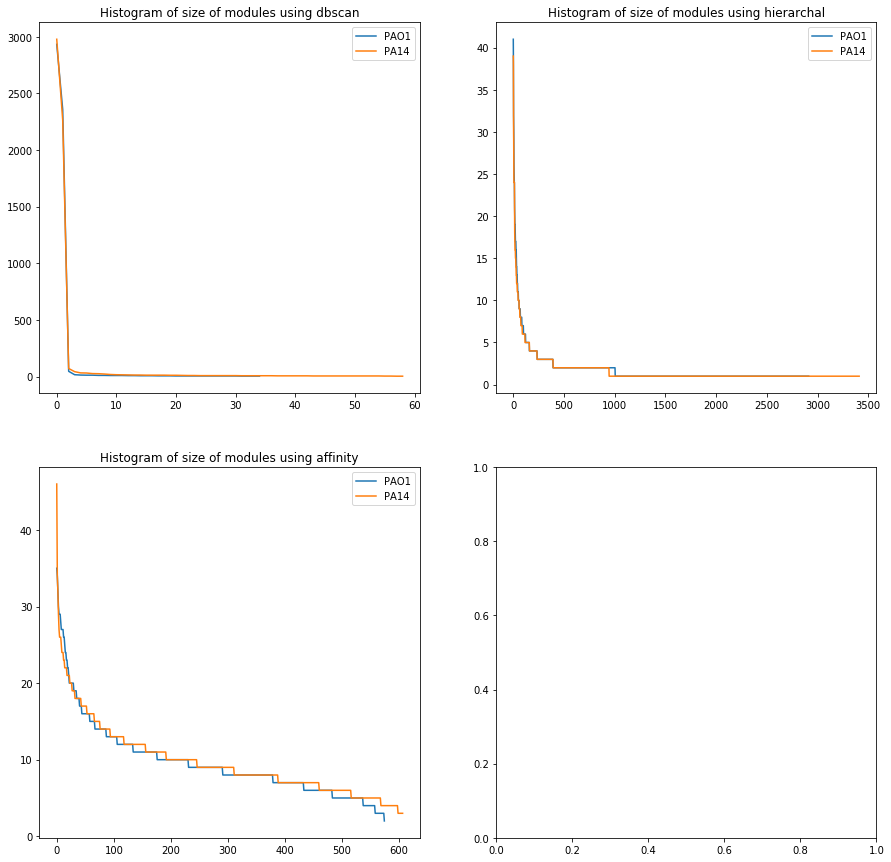

In [5]:
# Plot distribution of modules per clustering method
plot_dist_modules(clustering_method_list, gene_subset)

**Takeaway:**
Our expectation on size of modules would be 2-50 genes. Most operons have fewer than 10 genes and most regulons have fewer than 100 genes. Some examples that demonstrate the size of co-expression networks can be found in papers using ADAGE signatures to define modules:
* Figure 5 in [eADAGE paper](https://bmcbioinformatics.biomedcentral.com/track/pdf/10.1186/s12859-017-1905-4.pdf)
* Figure 7 in [Harty et al. paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6531624/)
* Figure 2 in [Doing et al. paper](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1008783)

What did we find? Which method follows our expectation?
* Looks like there is one large modules using DBSCAN clustering
* There are more even sized modules using hierarchal clustering and affinity propogation so we will probably use one of these 2 methods.

## Examine composition of modules

This is a negative control. We expect that genes within the same operon or regulon will cluster together (i.e. be within the same module). To test this we will calculate the probability that a pair of genes will be from the same module, given that they are both from the same regulon or operon. We will calculate this probability for each (module, regulon/operon) combination.

_Some definitions:_

[Operons](https://en.wikipedia.org/wiki/Operon#:~:text=An%20operon%20is%20made%20up,transcription%20of%20the%20structural%20genes.) are a group of genes that share a promoter (DNA sequence that is recognized by RNA polymerase and enables transcription) and an operator (DNA sequence that repressor binds to and blocks RNA polymerase). Therefore these group of genes are transcribed or turned off together (so we would expect a very high correlation amongst these genes)

[Regulons](https://en.wikipedia.org/wiki/Regulon) are a group of genes that are regulated by the same regulatory protein. A regulon can be composed of multiple operons.

In [6]:
# Load PAO1 regulon file
pao1_regulon_filename = paths.PAO1_REGULON

# Load operon files
pa14_operon_filename = paths.PA14_OPERON
pao1_operon_filename = paths.PAO1_OPERON

# Load membership for specific clustering method
pao1_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR,
    f"pao1_modules_{method_toexamine}_{gene_subset}_{processed}.tsv",
)
pa14_membership_filename = os.path.join(
    paths.LOCAL_DATA_DIR,
    f"pa14_modules_{method_toexamine}_{gene_subset}_{processed}.tsv",
)

pao1_membership = pd.read_csv(pao1_membership_filename, sep="\t", header=0, index_col=0)
pa14_membership = pd.read_csv(pa14_membership_filename, sep="\t", header=0, index_col=0)

In [7]:
print(pao1_membership.shape)
pao1_membership.head()

(5563, 1)


,module id
PA0001,415
PA0002,573
PA0003,92
PA0004,567
PA0005,0


In [8]:
print(pa14_membership.shape)
pa14_membership.head()

(5887, 1)


,module id
PA14_55610,4
PA14_55600,19
PA14_55590,596
PA14_55580,425
PA14_55570,47


According to Jake relationships tend to be more meaningful if the module is smaller (e.g. if an operon with 5 genes is contained in a module consisting of 10 total genes, this seems more biologically/functionally meaningful than an operon with 5 genes contained in a module consisting of 500 genes).

To correct for the single or couple very large modules, we will remove them from the analysis

In [9]:
# Get module ids that exceed size limit
module_todrop = (
    pao1_membership["module id"]
    .value_counts()[
        (pao1_membership["module id"].value_counts() > module_size_threshold)
    ]
    .index
)

print(module_todrop)

Int64Index([], dtype='int64')


In [10]:
# Get genes to drop
genes_todrop = pao1_membership[pao1_membership["module id"].isin(module_todrop)].index

# Drop genes
pao1_membership = pao1_membership.drop(genes_todrop)

### Format operon/regulon files

* Remove genes from operons/regulons that don't have membership information
* Make random list of genes with matched size
* There are many single gene operons, we will remove these for this analysis

In [11]:
# Read file
pao1_operon = pd.read_csv(pao1_operon_filename, index_col=0, header=0)
pa14_operon = pd.read_csv(pa14_operon_filename, index_col=0, header=0)

pao1_regulon = pd.read_csv(pao1_regulon_filename, index_col=0, header=0)

print(pao1_operon.shape)
pao1_operon.head()

(3816, 8)


,operon_name,locus_tag,start,end,strand,gene_name,source_database,pmid
operon-id,,,,,,,,
operon-1,dnaA-dnaN-recF-gyrB,PA0001,483,2027,1,dnaA,DOOR,18988623
operon-1,dnaA-dnaN-recF-gyrB,PA0002,2056,3159,1,dnaN,DOOR,18988623
operon-1,dnaA-dnaN-recF-gyrB,PA0003,3169,4278,1,recF,DOOR,18988623
operon-1,dnaA-dnaN-recF-gyrB,PA0004,4275,6695,1,gyrB,DOOR,18988623
operon-2,PA0006-lptA,PA0005,7018,7791,-1,lptA,DOOR,18988623


In [12]:
print(pa14_operon.shape)
pa14_operon.head()

(3756, 8)


,operon_name,locus_tag,start,end,strand,gene_name,source_database,pmid
operon-id,,,,,,,,
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00010,483,2027,1,dnaA,DOOR,18988623
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00020,2056,3159,1,dnaN,DOOR,18988623
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00030,3169,4278,1,recF,DOOR,18988623
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00050,4275,6695,1,gyrB,DOOR,18988623
operon-8959,PA14_00070-PA14_00060,PA14_00060,7018,7791,-1,NaN,DOOR,18988623


In [13]:
print(pao1_regulon.shape)
pao1_regulon.head()

(31, 2)


,Lengths,Genes
Regulon,,
Anr_regulon,72,PA5475;PA1673;PA5027;PA3337;PA4348;PA4347;PA43...
PhoB_regulon,160,PA0050;PA0051;PA0082;PA0102;PA0105;PA0165;PA01...
PvdR_regulon,14,PA2386;PA2399;PA2397;PA2396;PA2425;PA2413;PA24...
PchR_regulon,12,PA4231;PA4230;PA4229;PA4228;PA4226;PA4225;PA42...
AlgU_regulon,238,PA0059;PA0060;PA0061;PA0062;PA0071;PA0134;PA01...


In [14]:
# Convert "Genes" column from str to list for regulon dataset
pao1_regulon["Genes"] = pao1_regulon["Genes"].str.split(";")

In [15]:
# Check if genes within operon/regulon have membership information
# Only keep genes that are found in "pao1_membership"
pao1_regulon["Genes_processed"] = pao1_regulon["Genes"].apply(
    lambda list_genes: [
        gene_id for gene_id in list_genes if gene_id in pao1_membership.index
    ]
)

In [16]:
# Add size of the operons
pao1_operon["size"] = pao1_operon["operon_name"].map(
    pao1_operon.groupby("operon_name")["locus_tag"].count()
)
pa14_operon["size"] = pa14_operon["operon_name"].map(
    pa14_operon.groupby("operon_name")["locus_tag"].count()
)

In [17]:
pao1_operon.head()

,operon_name,locus_tag,start,end,strand,gene_name,source_database,pmid,size
operon-id,,,,,,,,,
operon-1,dnaA-dnaN-recF-gyrB,PA0001,483,2027,1,dnaA,DOOR,18988623,4
operon-1,dnaA-dnaN-recF-gyrB,PA0002,2056,3159,1,dnaN,DOOR,18988623,4
operon-1,dnaA-dnaN-recF-gyrB,PA0003,3169,4278,1,recF,DOOR,18988623,4
operon-1,dnaA-dnaN-recF-gyrB,PA0004,4275,6695,1,gyrB,DOOR,18988623,4
operon-2,PA0006-lptA,PA0005,7018,7791,-1,lptA,DOOR,18988623,2


In [18]:
pa14_operon.head()

,operon_name,locus_tag,start,end,strand,gene_name,source_database,pmid,size
operon-id,,,,,,,,,
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00010,483,2027,1,dnaA,DOOR,18988623,4
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00020,2056,3159,1,dnaN,DOOR,18988623,4
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00030,3169,4278,1,recF,DOOR,18988623,4
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00050,4275,6695,1,gyrB,DOOR,18988623,4
operon-8959,PA14_00070-PA14_00060,PA14_00060,7018,7791,-1,NaN,DOOR,18988623,2


In [19]:
pao1_operon_len = []
for grp_name, grp_df in pao1_operon.groupby("operon_name"):
    pao1_operon_len.append(grp_df.shape[0])

In [20]:
pa14_operon_len = []
for grp_name, grp_df in pa14_operon.groupby("operon_name"):
    pa14_operon_len.append(grp_df.shape[0])

In [21]:
# Update length based on filtered gene list ("Genes_processed" column)
pao1_regulon["size"] = pao1_regulon["Genes_processed"].str.len()

In [22]:
# If number genes in operon are 1 then remove
# Drop operons and regulons that have 0 genes due to no module filtering
pao1_operon = pao1_operon.drop(pao1_operon.query("size<=1").index)
pa14_operon = pa14_operon.drop(pa14_operon.query("size<=1").index)
pao1_regulon = pao1_regulon.drop(pao1_regulon.query("size<=1").index)

In [23]:
print(pao1_operon.shape)
pao1_operon.head()

(3776, 9)


,operon_name,locus_tag,start,end,strand,gene_name,source_database,pmid,size
operon-id,,,,,,,,,
operon-1,dnaA-dnaN-recF-gyrB,PA0001,483,2027,1,dnaA,DOOR,18988623,4
operon-1,dnaA-dnaN-recF-gyrB,PA0002,2056,3159,1,dnaN,DOOR,18988623,4
operon-1,dnaA-dnaN-recF-gyrB,PA0003,3169,4278,1,recF,DOOR,18988623,4
operon-1,dnaA-dnaN-recF-gyrB,PA0004,4275,6695,1,gyrB,DOOR,18988623,4
operon-2,PA0006-lptA,PA0005,7018,7791,-1,lptA,DOOR,18988623,2


In [24]:
print(pa14_operon.shape)
pa14_operon.head()

(3756, 9)


,operon_name,locus_tag,start,end,strand,gene_name,source_database,pmid,size
operon-id,,,,,,,,,
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00010,483,2027,1,dnaA,DOOR,18988623,4
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00020,2056,3159,1,dnaN,DOOR,18988623,4
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00030,3169,4278,1,recF,DOOR,18988623,4
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00050,4275,6695,1,gyrB,DOOR,18988623,4
operon-8959,PA14_00070-PA14_00060,PA14_00060,7018,7791,-1,NaN,DOOR,18988623,2


In [25]:
print(pao1_regulon.shape)
pao1_regulon.head()

(31, 4)


,Lengths,Genes,Genes_processed,size
Regulon,,,,
Anr_regulon,72,"[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...","[PA5475, PA1673, PA5027, PA3337, PA4348, PA434...",72
PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...","[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...",160
PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...","[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...",14
PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...","[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...",12
AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...","[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...",228


### Get regulon information using PA14 ids

Note that we can only do this mapping for core genes

In [26]:
pa14_regulon = pao1_regulon.copy()

In [27]:
# Get mapping between PAO1 and PA14 genes using PAO1 reference
gene_annot_file = paths.GENE_PAO1_ANNOT
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(gene_annot_file, "pao1")
gene_mapping_pao1.head()

,Name,Product.Name,GeneID.(PAO1),PA14_ID,annotation,num_mapped_genes
PAO1_ID,,,,,,
PA0001,dnaA,chromosomal replication initiator protein DnaA,878417.0,PA14_00010,core,1.0
PA0002,dnaN,"DNA polymerase III, beta chain",879244.0,PA14_00020,core,1.0
PA0003,recF,RecF protein,879229.0,PA14_00030,core,1.0
PA0004,gyrB,DNA gyrase subunit B,879230.0,PA14_00050,core,1.0
PA0005,lptA,"lysophosphatidic acid acyltransferase, LptA",877576.0,PA14_00060,core,1.0


In [28]:
pa14_regulon["Genes_processed"] = pa14_regulon["Genes_processed"].apply(
    lambda pao1_gene_list: gene_mapping_pao1.loc[pao1_gene_list, "PA14_ID"].values
)

In [29]:
# Update length based on filtered gene list ("Genes_processed" column)
pa14_regulon["size"] = pa14_regulon["Genes_processed"].str.len()

In [30]:
# If genes didn't map then drop operon/regulon
pa14_regulon = pa14_regulon.drop(
    pa14_regulon[
        pa14_regulon["Genes_processed"].apply(
            lambda gene_list: pd.isna(gene_list).any()
        )
    ].index
)

print(pa14_regulon.shape)

(22, 4)


In [31]:
# If number genes in operon are 1 then remove
# Drop operons and regulons that have 0 genes due to no module filtering
pa14_regulon = pa14_regulon.drop(pa14_regulon.query("size<=1").index)

In [32]:
print(pa14_regulon.shape)
pa14_regulon.head()

(22, 4)


,Lengths,Genes,Genes_processed,size
Regulon,,,,
PhoB_regulon,160,"[PA0050, PA0051, PA0082, PA0102, PA0105, PA016...","[PA14_00630, PA14_00640, PA14_00990, PA14_0124...",160
PvdR_regulon,14,"[PA2386, PA2399, PA2397, PA2396, PA2425, PA241...","[PA14_33810, PA14_33650, PA14_33690, PA14_3370...",14
PchR_regulon,12,"[PA4231, PA4230, PA4229, PA4228, PA4226, PA422...","[PA14_09210, PA14_09220, PA14_09230, PA14_0924...",12
AlgU_regulon,238,"[PA0059, PA0060, PA0061, PA0062, PA0071, PA013...","[PA14_00710, PA14_00720, PA14_00730, PA14_0074...",228
PqsR_regulon,133,"[PA0122, PA0355, PA0567, PA0996, PA0997, PA099...","[PA14_01490, PA14_04650, PA14_07370, PA14_5143...",130


/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'count')

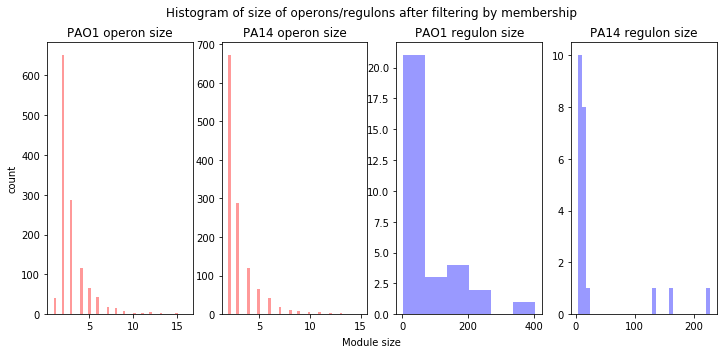

In [33]:
# Quick look at distribution of size of regulons and operons
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12, 5))

sns.distplot(
    pao1_operon_len,
    label="PAO1 operon size",
    color="red",
    kde=False,
    ax=axes[0],
)

sns.distplot(
    pa14_operon_len,
    label="PA14 operon size",
    color="red",
    kde=False,
    ax=axes[1],
)

sns.distplot(
    pao1_regulon["size"],
    label="PAO1 regulon size",
    color="blue",
    kde=False,
    ax=axes[2],
)

sns.distplot(
    pa14_regulon["size"],
    label="PA14 regulon size",
    color="blue",
    kde=False,
    ax=axes[3],
)

fig.suptitle(
    "Histogram of size of operons/regulons after filtering by membership",
    fontsize=12,
)
axes[0].set_title("PAO1 operon size")
axes[1].set_title("PA14 operon size")
axes[2].set_title("PAO1 regulon size")
axes[3].set_title("PA14 regulon size")

axes[2].set_xlabel("")
axes[3].set_xlabel("")

fig.text(0.5, 0.04, "Module size", ha="center")
axes[0].set_ylabel("count")

### Calculate the probabilities

What is the probability that gene x and y are in the same module given that they are both from the same regulon/operon?

Given: regulon A and module B
$$
Pr(x,y \in B|x,y \in A) = \frac{Pr(x,y \in B \cap x,y \in A)}{Pr(x,y \in A)}
$$

In [34]:
def coverage_of_genesets(module_df, genesets_df, geneset_type):

    total_genes = module_df.shape[0]
    rows = []

    for module_id, module_genes_df in module_df.groupby("module id"):

        # Pr(x,y in operon/regulon A)
        if geneset_type == "operon":
            # Dictionary of probabilities for a given module mapped to all operons
            operon_probs = {}
            for operon_id, operon_df in genesets_df.groupby("operon_name"):
                num_geneset = operon_df.shape[0]
                pr_denom = (num_geneset / total_genes) ** 2

                # Pr(x,y in module B | x,y in operon A)
                operon_df = operon_df.set_index("locus_tag")
                shared_genes = set(operon_df.index).intersection(module_genes_df.index)

                pr_joint = (len(shared_genes) / total_genes) ** 2
                pr_final = pr_joint / pr_denom

                operon_probs[operon_id] = pr_final

            # Save only the best matched operon-module based on the p-value
            (best_operon_id, best_prob) = max(operon_probs.items(), key=lambda k: k[1])

            rows.append(
                {
                    "module id": module_id,
                    "operon id": best_operon_id,
                    "pr(x,y in module|x,y in operon)": best_prob,
                }
            )

        else:
            # Dictionary of probabilities for a given module mapped to all operons
            regulon_probs = {}
            for regulon_id in genesets_df.index:
                num_geneset = genesets_df.loc[regulon_id, "size"]
                pr_denom = (num_geneset / total_genes) ** 2

                # Pr(x,y in module B | x,y in operon A)
                shared_genes = set(
                    genesets_df.loc[regulon_id, "Genes_processed"]
                ).intersection(module_genes_df.index)
                pr_joint = (len(shared_genes) / total_genes) ** 2
                pr_final = (pr_joint) / pr_denom

            regulon_probs[regulon_id] = pr_final

            # Save only the best matched operon-module based on the p-value
            (best_regulon_id, best_prob) = max(
                regulon_probs.items(), key=lambda k: k[1]
            )

            rows.append(
                {
                    "module id": module_id,
                    "regulon id": best_regulon_id,
                    "pr(x,y in module|x,y in regulon)": best_prob,
                }
            )
    out_df = pd.DataFrame(rows)
    if geneset_type == "operon":
        assert (out_df["pr(x,y in module|x,y in operon)"] > 1).sum() == 0
    else:
        assert (out_df["pr(x,y in module|x,y in regulon)"] > 1).sum() == 0
    return out_df

In [35]:
%%time
pao1_operon_prob = coverage_of_genesets(pao1_membership, pao1_operon, "operon")
pao1_operon_prob.head()

CPU times: user 4min 51s, sys: 221 ms, total: 4min 51s
Wall time: 4min 51s


,module id,operon id,"pr(x,y in module|x,y in operon)"
0,0,PA0006-lptA,0.25
1,1,fmt-PA0017-trkA,1.00
2,2,PlcB-PA0027-PA0028,1.00
3,3,trpB-trpA,1.00
4,4,PA0058-osmC,0.25


In [36]:
%%time
pa14_operon_prob = coverage_of_genesets(pa14_membership, pa14_operon, "operon")
pa14_operon_prob.head()

CPU times: user 5min 6s, sys: 204 ms, total: 5min 6s
Wall time: 5min 7s


,module id,operon id,"pr(x,y in module|x,y in operon)"
0,0,PA14_55520-PA14_55530,1.00
1,1,PA14_55380-exbB2-exbD2-PA14_55330-PA14_55320-P...,1.00
2,2,PA14_47260-PA14_47250,0.25
3,3,PA14_61890-rimI,0.25
4,4,PA14_55140-gloA2,1.00


In [37]:
%%time
pao1_regulon_prob = coverage_of_genesets(pao1_membership, pao1_regulon, "regulon")
pao1_regulon_prob.head()

CPU times: user 305 ms, sys: 0 ns, total: 305 ms
Wall time: 305 ms


,module id,regulon id,"pr(x,y in module|x,y in regulon)"
0,0,PhhR_regulon,0.0
1,1,PhhR_regulon,0.0
2,2,PhhR_regulon,0.0
3,3,PhhR_regulon,0.0
4,4,PhhR_regulon,0.0


In [38]:
%%time
if gene_subset == "core":
    pa14_regulon_prob = coverage_of_genesets(pa14_membership, pa14_regulon, "regulon")
    pa14_regulon_prob.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [39]:
# As a baseline make a membership df mapping genes to a shuffled set of module ids
pao1_membership_shuffle = pao1_membership.copy()
pao1_membership_shuffle["module id"] = np.random.permutation(
    pao1_membership_shuffle["module id"].values
)

pa14_membership_shuffle = pa14_membership.copy()
pa14_membership_shuffle["module id"] = np.random.permutation(
    pa14_membership_shuffle["module id"].values
)

In [40]:
%%time
pao1_operon_shuffle_prob = coverage_of_genesets(
    pao1_membership_shuffle, pao1_operon, "operon"
)
pao1_operon_shuffle_prob.head()

CPU times: user 4min 41s, sys: 59.8 ms, total: 4min 41s
Wall time: 4min 42s


,module id,operon id,"pr(x,y in module|x,y in operon)"
0,0,PA3462-PA3463,0.250000
1,1,PA4805-PA4804,0.250000
2,2,PA1763-PA1764-PA1765,0.111111
3,3,PA1968-PA1969,0.250000
4,4,PA5568-PA5567,0.250000


In [41]:
%%time
pa14_operon_shuffle_prob = coverage_of_genesets(
    pa14_membership_shuffle, pao1_operon, "operon"
)
pa14_operon_shuffle_prob.head()

CPU times: user 4min 59s, sys: 40 ms, total: 4min 59s
Wall time: 4min 59s


,module id,operon id,"pr(x,y in module|x,y in operon)"
0,0,H2-T6SS gene cluster,0.0
1,1,H2-T6SS gene cluster,0.0
2,2,H2-T6SS gene cluster,0.0
3,3,H2-T6SS gene cluster,0.0
4,4,H2-T6SS gene cluster,0.0


In [42]:
%%time
pao1_regulon_shuffle_prob = coverage_of_genesets(
    pao1_membership_shuffle, pao1_regulon, "regulon"
)
pao1_regulon_shuffle_prob.head()

CPU times: user 310 ms, sys: 0 ns, total: 310 ms
Wall time: 310 ms


,module id,regulon id,"pr(x,y in module|x,y in regulon)"
0,0,PhhR_regulon,0.0
1,1,PhhR_regulon,0.0
2,2,PhhR_regulon,0.0
3,3,PhhR_regulon,0.0
4,4,PhhR_regulon,0.0


In [43]:
%%time
if gene_subset == "core":
    pa14_regulon_shuffle_prob = coverage_of_genesets(
        pa14_membership_shuffle, pa14_regulon, "regulon"
    )
    pa14_regulon_shuffle_prob.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


## Plot distribution of probabilities

Can we identify those operons, regulons that have high probability of being in the same module

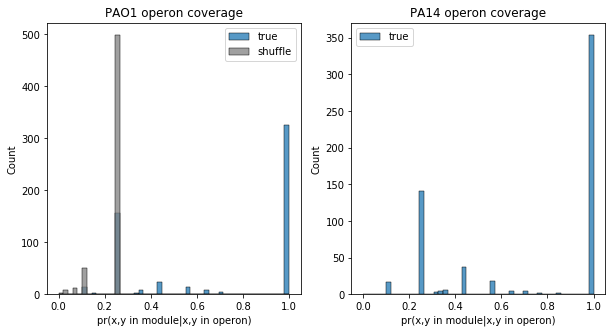

In [44]:
# Plot operon coverage
# Note: We are only plotting the probabilities greater than 0 since there were many operons that had
# a 0 probability, likely due to the small size of the operons
# All probabilities for PA14 shuffled data is 0 which is why the plot is blank
fig_operon, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
bins_shared = np.linspace(0, 1)

fig_operon = sns.histplot(
    pao1_operon_prob.loc[
        pao1_operon_prob["pr(x,y in module|x,y in operon)"] > 0,
        "pr(x,y in module|x,y in operon)",
    ],
    bins=bins_shared,
    ax=axes[0],
    label="true",
)
fig_operon = sns.histplot(
    pa14_operon_prob.loc[
        pa14_operon_prob["pr(x,y in module|x,y in operon)"] > 0,
        "pr(x,y in module|x,y in operon)",
    ],
    bins=bins_shared,
    ax=axes[1],
    label="true",
)
fig_operon = sns.histplot(
    pao1_operon_shuffle_prob.loc[
        pao1_operon_shuffle_prob["pr(x,y in module|x,y in operon)"] > 0,
        "pr(x,y in module|x,y in operon)",
    ],
    bins=bins_shared,
    color="grey",
    ax=axes[0],
    label="shuffle",
)
fig_operon = sns.histplot(
    pa14_operon_shuffle_prob.loc[
        pa14_operon_shuffle_prob["pr(x,y in module|x,y in operon)"] > 0,
        "pr(x,y in module|x,y in operon)",
    ],
    bins=bins_shared,
    color="grey",
    ax=axes[1],
    label="shuffle",
)

axes[0].set_title("PAO1 operon coverage")
axes[1].set_title("PA14 operon coverage")

legend = axes[0].legend()
legend = axes[1].legend()

In [45]:
pao1_operon_prob[pao1_operon_prob["pr(x,y in module|x,y in operon)"] < 0.5]

,module id,operon id,"pr(x,y in module|x,y in operon)"
0,0,PA0006-lptA,0.25
4,4,PA0058-osmC,0.25
5,5,PA0062-PA0061,0.25
8,8,PA4735-PA4736,0.25
9,9,H2-T6SS gene cluster,0.00
...,...,...,...
559,559,PA0034-hptC,0.25
560,560,PA5431-PA5430,0.25
565,565,PA0332-PA0333,0.25
567,567,glmU-PA5551,0.25


In [46]:
# What are these operons that have a low prbabilities
# Why are some operons not likely to be within the same module?
# Based on the describe statistics, there doesn't appear to be a clear reasoning
# Overall, it is good that most operons have a high probability of being found in the same module
low_pao1_prob_operons = pao1_operon_prob[
    pao1_operon_prob["pr(x,y in module|x,y in operon)"] < 0.5
]["operon id"]
high_pao1_prob_operons = pao1_operon_prob[
    pao1_operon_prob["pr(x,y in module|x,y in operon)"] >= 0.5
]["operon id"]
pao1_operon_tmp = pao1_operon.set_index("operon_name")

In [47]:
pao1_operon_tmp.loc[low_pao1_prob_operons].describe()

,start,end,strand,pmid,size
count,6.940000e+02,6.940000e+02,694.000000,6.940000e+02,694.000000
mean,2.764685e+06,2.765642e+06,0.123919,1.964566e+07,5.772334
std,1.780427e+06,1.780405e+06,0.993008,1.545658e+06,5.244392
min,7.018000e+03,7.791000e+03,-1.000000,8.394980e+06,2.000000
25%,1.518914e+06,1.519546e+06,-1.000000,1.898862e+07,2.000000
50%,1.832588e+06,1.833472e+06,1.000000,1.898862e+07,3.000000
75%,4.493062e+06,4.493742e+06,1.000000,1.898862e+07,8.000000
max,6.246326e+06,6.247690e+06,1.000000,2.266549e+07,16.000000


In [48]:
pao1_operon_tmp.loc[high_pao1_prob_operons].describe()

,start,end,strand,pmid,size
count,1.167000e+03,1.167000e+03,1167.000000,1.167000e+03,1167.000000
mean,2.952386e+06,2.953454e+06,-0.021422,1.900065e+07,4.451585
std,1.769737e+06,1.769761e+06,1.000199,8.417723e+05,3.008709
min,1.736600e+04,1.873900e+04,-1.000000,2.115874e+06,2.000000
25%,1.540447e+06,1.541938e+06,-1.000000,1.898862e+07,2.000000
50%,2.733120e+06,2.734160e+06,-1.000000,1.898862e+07,3.000000
75%,4.384632e+06,4.385522e+06,1.000000,1.898862e+07,5.000000
max,6.254428e+06,6.254808e+06,1.000000,2.266549e+07,16.000000


In [49]:
low_pa14_prob_operons = pa14_operon_prob[
    pa14_operon_prob["pr(x,y in module|x,y in operon)"] < 0.5
]["operon id"]
high_pa14_prob_operons = pa14_operon_prob[
    pa14_operon_prob["pr(x,y in module|x,y in operon)"] >= 0.5
]["operon id"]
pa14_operon_tmp = pa14_operon.set_index("operon_name")

In [50]:
pa14_operon_tmp.loc[low_pa14_prob_operons].sort_values(by="size")

,locus_tag,start,end,strand,gene_name,source_database,pmid,size
operon_name,,,,,,,,
PA14_47260-PA14_47250,PA14_47250,4209501,4209887,-1,NaN,DOOR,18988623,2
PA14_43130-PA14_43110,PA14_43130,3841678,3842844,-1,NaN,DOOR,18988623,2
PA14_43130-PA14_43110,PA14_43110,3841020,3841622,-1,NaN,DOOR,18988623,2
PA14_04160-PA14_04180,PA14_04180,374152,374502,1,NaN,DOOR,18988623,2
PA14_04160-PA14_04180,PA14_04160,373079,374068,1,NaN,DOOR,18988623,2
...,...,...,...,...,...,...,...,...
fliL-fliM-fliN-fliO-fliP-fliQ-fliR-flhB-PA14_45710-PA14_45700,PA14_45740,4067897,4068673,-1,fliR,DOOR,18988623,10
fliL-fliM-fliN-fliO-fliP-fliQ-fliR-flhB-PA14_45710-PA14_45700,PA14_45760,4068673,4068942,-1,fliQ,DOOR,18988623,10
fliL-fliM-fliN-fliO-fliP-fliQ-fliR-flhB-PA14_45710-PA14_45700,PA14_45780,4069751,4070203,-1,fliO,DOOR,18988623,10


In [51]:
pa14_operon_tmp.loc[high_pa14_prob_operons].sort_values(by="size")

,locus_tag,start,end,strand,gene_name,source_database,pmid,size
operon_name,,,,,,,,
PA14_55520-PA14_55530,PA14_55520,4941752,4942201,1,hxcU,DOOR,18988623,2
PA14_43660-PA14_43670,PA14_43670,3887946,3889901,1,NaN,DOOR,18988623,2
PA14_21710-PA14_21720,PA14_21710,1887467,1888054,1,NaN,DOOR,18988623,2
PA14_21710-PA14_21720,PA14_21720,1888121,1888975,1,NaN,DOOR,18988623,2
PA14_13330-PA14_13340,PA14_13330,1144659,1146221,1,NaN,DOOR,18988623,2
...,...,...,...,...,...,...,...,...
PA14_57460-mraW-ftsL-ftsI-murE-murF-mraY-murD-ftsW-murG-murC-ddl-ftsQ-ftsA-ftsZ,PA14_57330,5107191,5108633,-1,murC,DOOR,18988623,15
PA14_57460-mraW-ftsL-ftsI-murE-murF-mraY-murD-ftsW-murG-murC-ddl-ftsQ-ftsA-ftsZ,PA14_57320,5106235,5107194,-1,ddl,DOOR,18988623,15
PA14_57460-mraW-ftsL-ftsI-murE-murF-mraY-murD-ftsW-murG-murC-ddl-ftsQ-ftsA-ftsZ,PA14_57290,5104093,5105346,-1,ftsA,DOOR,18988623,15


In [52]:
pao1_operon_prob.describe()

,module id,"pr(x,y in module|x,y in operon)"
count,575.000000,575.000000
mean,287.000000,0.696402
std,166.132477,0.360578
min,0.000000,0.000000
25%,143.500000,0.250000
50%,287.000000,1.000000
75%,430.500000,1.000000
max,574.000000,1.000000


In [53]:
pao1_operon_shuffle_prob.describe()

,module id,"pr(x,y in module|x,y in operon)"
count,575.000000,575.000000
mean,287.000000,0.230301
std,166.132477,0.065338
min,0.000000,0.000000
25%,143.500000,0.250000
50%,287.000000,0.250000
75%,430.500000,0.250000
max,574.000000,1.000000


In [54]:
pa14_operon_prob.describe()

,module id,"pr(x,y in module|x,y in operon)"
count,607.000000,607.000000
mean,303.000000,0.718304
std,175.370085,0.349010
min,0.000000,0.000000
25%,151.500000,0.250000
50%,303.000000,1.000000
75%,454.500000,1.000000
max,606.000000,1.000000


In [55]:
pa14_operon_shuffle_prob.describe()

,module id,"pr(x,y in module|x,y in operon)"
count,607.000000,607.0
mean,303.000000,0.0
std,175.370085,0.0
min,0.000000,0.0
25%,151.500000,0.0
50%,303.000000,0.0
75%,454.500000,0.0
max,606.000000,0.0


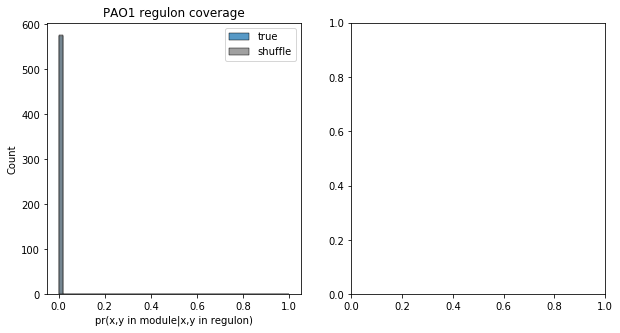

In [56]:
# Plot regulon coverage
fig_regulon, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
bins_shared = np.linspace(0, 1)

fig_regulon = sns.histplot(
    pao1_regulon_prob["pr(x,y in module|x,y in regulon)"],
    bins=bins_shared,
    ax=axes[0],
    label="true",
)
if gene_subset == "core":
    fig_regulon = sns.histplot(
        pa14_regulon_prob["pr(x,y in module|x,y in regulon)"],
        bins=bins_shared,
        ax=axes[1],
    )
    fig_regulon = sns.histplot(
        pa14_regulon_shuffle_prob["pr(x,y in module|x,y in regulon)"],
        bins=bins_shared,
        color="grey",
        ax=axes[1],
    )
fig_regulon = sns.histplot(
    pao1_regulon_shuffle_prob["pr(x,y in module|x,y in regulon)"],
    bins=bins_shared,
    color="grey",
    ax=axes[0],
    label="shuffle",
)

axes[0].set_title("PAO1 regulon coverage")
if gene_subset == "core":
    axes[1].set_title("PA14 regulon coverage")

legend = axes[0].legend()

In [57]:
pao1_regulon_prob.describe()

,module id,"pr(x,y in module|x,y in regulon)"
count,575.000000,575.000000
mean,287.000000,0.000870
std,166.132477,0.017562
min,0.000000,0.000000
25%,143.500000,0.000000
50%,287.000000,0.000000
75%,430.500000,0.000000
max,574.000000,0.413265


In [58]:
pao1_regulon_shuffle_prob.describe()

,module id,"pr(x,y in module|x,y in regulon)"
count,575.000000,575.000000
mean,287.000000,0.000124
std,166.132477,0.000787
min,0.000000,0.000000
25%,143.500000,0.000000
50%,287.000000,0.000000
75%,430.500000,0.000000
max,574.000000,0.005102


In [59]:
if gene_subset == "core":
    pa14_regulon_prob.describe()

In [60]:
if gene_subset == "core":
    pa14_regulon_shuffle_prob.describe()

**Takeaway:**
There is a higher probability that given pair of genes that are from the same operon, that they are also from the same module, compared to a randomly shuffled set of module assignments. Although there are some operons with low probabilties, overall genes in most operons have a high probability of being found in the same module.

We don't see as drastic of a skewing for the regulons, though the mean using the true module labels is slightly higher compared to the shuffle module labels.

Overall, this demonstrated that operons are well captured in our correlation matrix. However, a more effective way to assess this can be found [here](spell_vs_counts_experiment/1a_compare_SPELL_vs_counts_correlation.ipynb). Since the size of the regulons with respect to the non-regulon genes is so different, dividing by the total number of genes will drown out any signal we have.